In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)



Toggle code

# Plot map of the north eastern atlantic with OSNAP mooring position and EEL data used in the Rockall Trough article 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import iris
import iris.plot as iplt
import iris.quickplot as qplt

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

pathdir = '../../data/raw/csv_ctdgrid'
figuredir = '../figures/'

### Load location of EEL stations in the Rockall Trough

In [3]:

file3 = pathdir+'/'+'EELCTDandLADCP_refpos.csv'
dfloc = pd.read_csv(file3,sep=',', index_col=None, 
                     header=0)

# Make sure the station name are sorted by their distance along the section
sdfloc = dfloc.sort_values('Refdist', ascending=True)

# Reset row index 
sdfloc=sdfloc.reset_index(drop=True)

# Subsample to keep only the EEL stations used in the article (IB1 to S)'
i1=sdfloc.index[sdfloc['Staname']=='IB1'].values
i2=sdfloc.index[sdfloc['Staname']=='S'].values
ista = np.arange(i1,i2+1,1)
sdflocRT = sdfloc.iloc[ista,:]

# Print new subsample dataframe
sdflocRT


,Staname,Refdist,LonSta,LatSta,DepthSta
32,IB1,819.545112,-13.900,57.667,150
33,A,837.970829,-13.633,57.583,100
34,B,855.933634,-13.333,57.567,200
35,C,875.873120,-13.000,57.550,330
36,D,883.853506,-12.867,57.542,1000
37,E,897.845843,-12.633,57.533,1650
38,F,920.868131,-12.250,57.508,1800
39,G,944.816112,-11.850,57.492,1800
40,H,963.775388,-11.533,57.483,2020
41,I,976.802338,-11.317,57.467,750


In [4]:
# Mooring positions:
SAMSmoor={}

SAMSmoor['RTWB1']={}
SAMSmoor['RTWB1']['lon'] = -(12 + 42.3/60);
SAMSmoor['RTWB1']['lat']  = 57 +28.24/60;
SAMSmoor['RTWB1']['depth'] = [-1600,-50];

SAMSmoor['RTWB2']={}
SAMSmoor['RTWB2']['lon'] = -(12 + 19.87/60);
SAMSmoor['RTWB2']['lat']  = 57 +28.22/60;
SAMSmoor['RTWB2']['depth'] = [-1800,-1000];

SAMSmoor['RTEB1']={}
SAMSmoor['RTEB1']['lon'] = -(9 + 32.88/60);
SAMSmoor['RTEB1']['lat']  = 57 + 05.96/60;
SAMSmoor['RTEB1']['depth'] =  [-1800,-50];

SAMSmoor['RTADCP1']={}
SAMSmoor['RTADCP1']['lon'] = -(9 + 20.28/60);
SAMSmoor['RTADCP1']['lat'] = 57 + 6.18/60;
SAMSmoor['RTADCP1']['depth'] = [-750,0];

print(SAMSmoor.keys())

# The list of the moorings longitude and latitude can be accessed by:
SAMSmoor_coordinates = [(v['lon'],v['lat']) for (k,v) in SAMSmoor.items()]

print(f"\n Coordinates of SAMS mooring (lon,lat): {SAMSmoor_coordinates}")

dict_keys(['RTWB1', 'RTWB2', 'RTEB1', 'RTADCP1'])

 Coordinates of SAMS mooring (lon,lat): [(-12.705, 57.470666666666666), (-12.331166666666666, 57.470333333333336), (-9.548, 57.099333333333334), (-9.338, 57.103)]


<br><br>
## Plot North Atlantic Map with location of EEL stations


#### Plot a topography map using the etopo1 data from the NOAA opendap server. With iris we can slice the data before downloading it. Finally we will "print" our cube to check the metadata.

In [5]:
# Definition variables for maps
central_lon, central_lat = -10, 45
extent_extract = [-30, 10, 50, 70]
extent_map = [-26, 0, 51, 66]

In [6]:
def get_cube(url):
    coord_values = {'latitude':lambda cell: extent_extract[2] <= cell <= extent_extract[3],
                    'longitude': lambda cell: extent_extract[0] <= cell <= extent_extract[1]}
    constraint = iris.Constraint(coord_values=coord_values)
    bathy = iris.load_cube(url, constraint)
    return bathy

# try:
#     bathy = get_cube('/Users/locupe/Dropbox/Work/function_MATLAB/bathymetrie/bathy_gebco.nc')
# except:
#     bathy = get_cube('http://thredds.aoos.org/thredds/dodsC/GEBCO2014_NORTHERN_HEM.nc')

bathy = get_cube('http://thredds.aoos.org/thredds/dodsC/GEBCO2014_NORTHERN_HEM.nc') 
bathy = iris.util.squeeze(bathy)

print(bathy)

/Users/locupe/anaconda2/envs/analysis_eel_data/lib/python3.8/site-packages/iris/fileformats/cf.py:324: UserWarning: Missing CF-netCDF auxiliary coordinate variable 'y', referenced by netCDF variable 'elevation'
  warnings.warn(message % (name, nc_var_name))
/Users/locupe/anaconda2/envs/analysis_eel_data/lib/python3.8/site-packages/iris/fileformats/cf.py:324: UserWarning: Missing CF-netCDF auxiliary coordinate variable 'x', referenced by netCDF variable 'elevation'
  warnings.warn(message % (name, nc_var_name))
/Users/locupe/anaconda2/envs/analysis_eel_data/lib/python3.8/site-packages/iris/fileformats/cf.py:649: UserWarning: Missing CF-netCDF label variable 'y', referenced by netCDF variable 'elevation'
  warnings.warn(message % (name, nc_var_name))
/Users/locupe/anaconda2/envs/analysis_eel_data/lib/python3.8/site-packages/iris/fileformats/cf.py:649: UserWarning: Missing CF-netCDF label variable 'x', referenced by netCDF variable 'elevation'
  warnings.warn(message % (name, nc_var_name)

height_above_reference_ellipsoid / (m) (latitude: 2400; longitude: 4800)
     Dimension coordinates:
          latitude                              x                -
          longitude                             -                x
     Scalar coordinates:
          time: 2014-12-03 00:00:00
     Attributes:
          Conventions: CF-1.0
          History: Translated to CF-1.0 Conventions by Netcdf-Java CDM (NetcdfCFWriter)
Original...
          NCO: 4.4.8
          comment: The data in the GEBCO_2014 Grid should not be used for navigation or any...
          history: Tue May  5 08:08:12 2015: ncpdq -O -a lat,lon GEBCO_2014_2D_-180.0_0.0_180.0_90.0_lon.nc...
          institution: On behalf of the General Bathymetric Chart of the Oceans (GEBCO), the data...
          nco_openmp_thread_number: 1
          node_offset: 1
          references: Information on the data set is available from the GEBCO project web pages:...
          sdn_parameter_name: Sea floor height (above mean sea lev

<br><br>
### Plot the regional bathymetry map

In [7]:
import palettable

from palettable import colorbrewer
from palettable.cmocean.sequential import Ice_12 as ocean
# help(colorbrewer)
# colorbrewer.print_maps

In [8]:
plt.rcParams.update({'font.size': 14})

# Define a function to plot the background map
def plot_bathy_ENA(gridlines=True):
    """ Function to plot the map of the Eastern North Atlantic with the associated bathymetry

    plot_bathy_ENA()
    
    Returns:
    (fig, ax): Figure and axes objects generated by plt.subplots

    """
    
    land = colorbrewer.get_map('Accent', 'qualitative', 8)
    #ocean = colorbrewer.get_map('Blues', 'sequential', 6, reverse=True)
    colors = np.array(ocean.mpl_colors[-6:])

    levels = [-3000, -2000, -1250, -1000, -650, -200, 0]

    #titlefig = 'Map Eastern North Atlantic'

    fig, ax = plt.subplots(figsize=(12, 12),
                           subplot_kw=dict(projection=ccrs.Mercator(central_lon, central_lat)))
    countplt = iris.plot.contourf(bathy, levels, colors=colors, extend='both')
    countplt.cmap.set_under(ocean.mpl_colors[-7])
    countplt.cmap.set_over(land.mpl_colors[-1])

    cbar = plt.colorbar(countplt, ax=ax, orientation="vertical", pad=.05, aspect=40)  
    cbar.ax.set_ylabel('Depth (m)')
    
    ax.set_extent(extent_map)
 #   ax.set_title(f'{titlefig}')
    ax.coastlines('10m', color='k')

    if gridlines:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), ylocs=np.arange(52,68,2),
                          draw_labels=True, linewidth=1, color='gray', alpha=0.8, linestyle='-.')

        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    
    return (fig, ax)

In [9]:
plot_bathy_ENA?

Signature: plot_bathy_ENA(gridlines=True)
Docstring:
Function to plot the map of the Eastern North Atlantic with the associated bathymetry

plot_bathy_ENA()

Returns:
(fig, ax): Figure and axes objects generated by plt.subplots
File:      ~/Dropbox/Work/Python/Repos_perso/analysis_eel_data/notebooks/other/<ipython-input-8-7aeb4e1a9542>
Type:      function


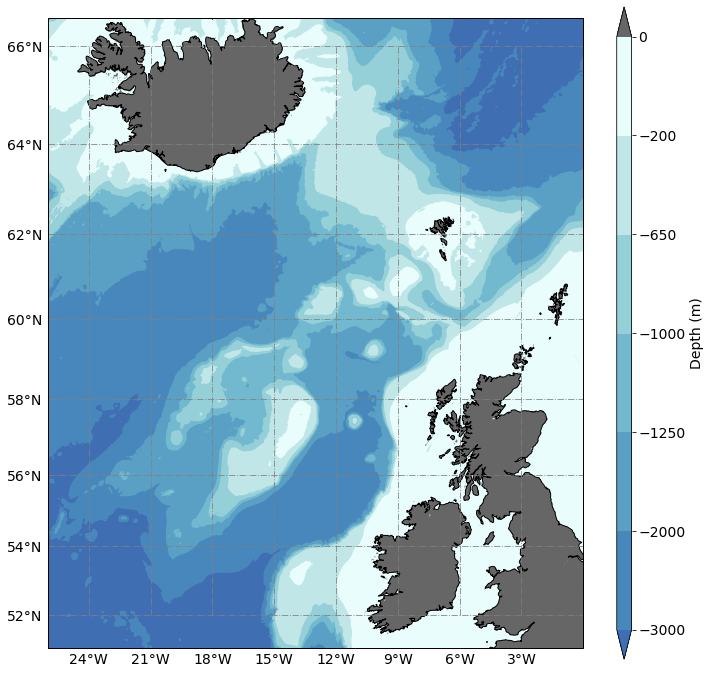

In [10]:
# plot map
(fig,ax)=plot_bathy_ENA()

<br><br>
#### Add the reference stations of the EEL section and OSNAP moorings

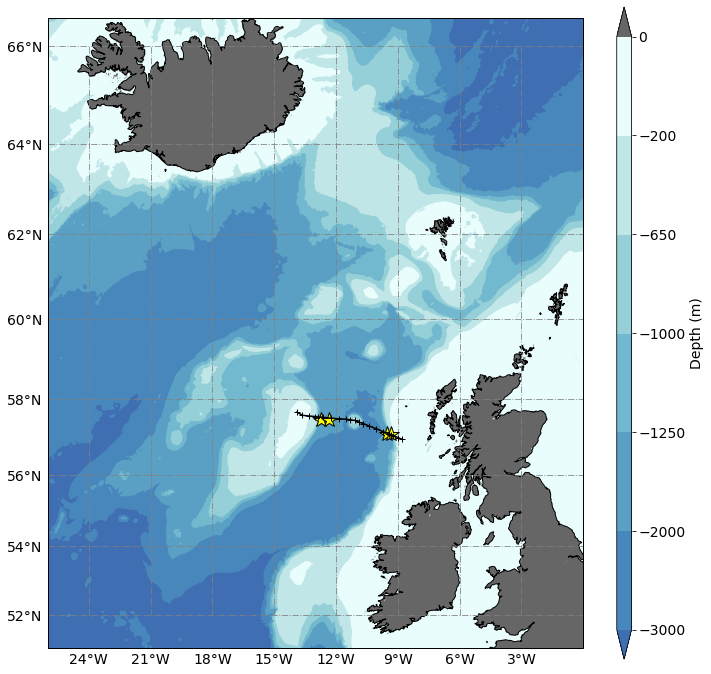

In [11]:
# OSNAP moorings
moor_lon = [v['lon'] for (k,v) in SAMSmoor.items()]
moor_lat = [v['lat'] for (k,v) in SAMSmoor.items()]
ax.plot(moor_lon, moor_lat,
         markeredgecolor='black', markerfacecolor='yellow',
        markersize=16,
        linestyle='none', marker='*', transform=ccrs.PlateCarree())

# EEL section
ax.plot(sdflocRT['LonSta'], sdflocRT['LatSta'],
         color='black', linestyle='-', marker='+', transform=ccrs.PlateCarree())


fig.savefig(figuredir+'00_Map_Eastern_NA_withEELsec.pdf')   
fig

<br><br>
#### Plot regional zoom with station label

Rockall Trough area

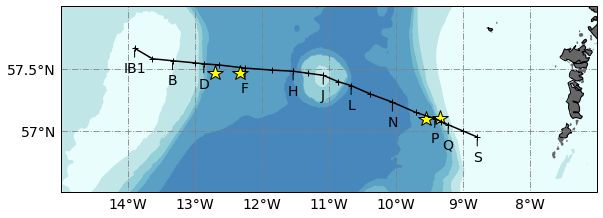

In [12]:
# Plot another version of the map without gridlines
(fig,ax)=plot_bathy_ENA(gridlines=False)

# OSNAP moorings
moor_lon = [v['lon'] for (k,v) in SAMSmoor.items()]
moor_lat = [v['lat'] for (k,v) in SAMSmoor.items()]
ax.plot(moor_lon, moor_lat,
         markeredgecolor='black', markerfacecolor='yellow',
        markersize=16,
        linestyle='none', marker='*', transform=ccrs.PlateCarree())

# EEL
ax.plot(sdflocRT['LonSta'], sdflocRT['LatSta'],
         color='black', linestyle='-', marker='+', transform=ccrs.PlateCarree())


# Annotate Station labels
transform = ccrs.PlateCarree()._as_mpl_transform(ax)
(mm,nn)=sdflocRT.shape
colorano='black'

# Display station name bottom left of section for station east of -16W 
indexsta = sdflocRT[(sdflocRT['LonSta']>=-16) ].index.values
for iii in indexsta[::2]:
    ax.annotate(sdflocRT.loc[iii,'Staname'], # this is the text
                 (sdflocRT.loc[iii,'LonSta'],sdflocRT.loc[iii,'LatSta']), # this is the point to label
                 ha='center',
                 va='center',
                 color=colorano,
                 xytext=(0, -20), 
                 textcoords='offset points', 
                 arrowprops=dict(arrowstyle='-',
                                 color=colorano),
                 xycoords = transform) # horizontal alignment can be left, right or center


#  Zoom on eastern part of the EEL
ax.set_extent([-15, -7, 56.5, 58], crs=ccrs.PlateCarree())

# delete colorbar
fig.delaxes(fig.axes[1])

# Plot Gridlines for the zoomed map
gl = ax.gridlines(crs=ccrs.PlateCarree(), ylocs=np.arange(52,68,0.5),
                      draw_labels=True, linewidth=1, color='gray', alpha=0.8, linestyle='-.')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER



## Plot in a single file the main map and the zoomed map using subplots

Parameters definition

In [13]:
# general definitions
land = colorbrewer.get_map('Accent', 'qualitative', 8)
#ocean = colorbrewer.get_map('Blues', 'sequential', 6, reverse=True)
colors = np.array(ocean.mpl_colors[-6:])
levels = [-3000, -2000, -1250, -1000, -650, -200, 0]

colorano='black'

extent_map = [-28.1, 0.1, 51, 66]

zoombox = [-15.1, -6.9, 56.2, 58.3]
central_lon, central_lat = -10, 45

\
Load additional libraries

In [14]:
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

\
Plot

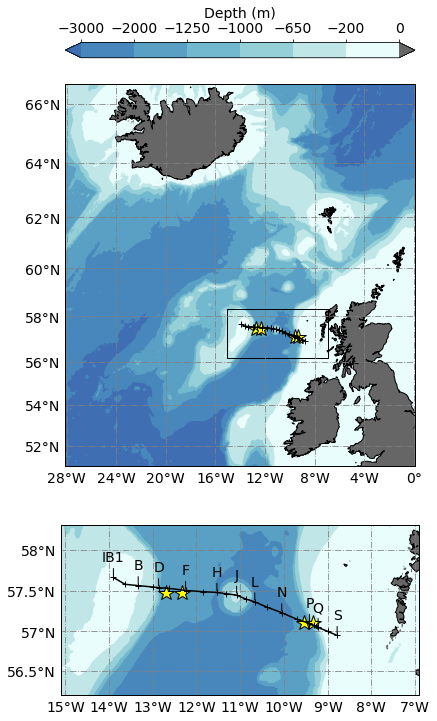

In [15]:
# Setting up the plot surface
fig= plt.figure(figsize=(12, 12)) #, constrained_layout=True)
gs = GridSpec(nrows=2, ncols=1, height_ratios=[1,0.4])

#------------------------------------------------------------------------------------
# Main ax (main map)
ax2 = fig.add_subplot(gs[0],projection=ccrs.Mercator(central_lon, central_lat))
countplt = iris.plot.contourf(bathy, levels, colors=colors, extend='both')
countplt.cmap.set_under(ocean.mpl_colors[-7])
countplt.cmap.set_over(land.mpl_colors[-1])
  
# Set the colormap limits
plt.clim([np.min(levels),np.max(levels)])


# Set the geographical limits
ax2.set_extent(extent_map)

# PLots coast line
ax2.coastlines('10m', color='k')

# Gridlines
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                   linewidth=1, color='gray', alpha=0.8, linestyle='-.')
gl.ylocator = mticker.FixedLocator(np.arange(50,70,2))
gl.xlocator = mticker.FixedLocator(np.arange(-28,4,4))

gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# OSNAP moorings
moor_lon = [v['lon'] for (k,v) in SAMSmoor.items()]
moor_lat = [v['lat'] for (k,v) in SAMSmoor.items()]
ax2.plot(moor_lon, moor_lat,
         markeredgecolor='black', markerfacecolor='yellow',
        markersize=16,
        linestyle='none', marker='*', transform=ccrs.PlateCarree())

# EEL section
ax2.plot(sdflocRT['LonSta'], sdflocRT['LatSta'],
         color='black', linestyle='-', marker='+', transform=ccrs.PlateCarree())


# Add rectangle showing zoom
rectzoomRT = [zoombox[0], zoombox[2], zoombox[1]-zoombox[0],zoombox[3]-zoombox[2]]

ax2.add_patch(mpatches.Rectangle(xy=rectzoomRT[0:2], width=rectzoomRT[2], height=rectzoomRT[3], 
                                 alpha=1,
                                 fill=False,
                                 color='black',
                                 transform=ccrs.PlateCarree())
             )

    
#------------------------------------------------------------------------------------
# Second axes(zoom RT)
ax1 = fig.add_subplot(gs[1],projection=ccrs.Mercator(central_lon, central_lat))
countplt = iris.plot.contourf(bathy, levels, colors=colors, extend='both')
countplt.cmap.set_under(ocean.mpl_colors[-7])
countplt.cmap.set_over(land.mpl_colors[-1])

# Set the colormap limits
plt.clim([np.min(levels),np.max(levels)])


#  Plot coast line
ax1.coastlines('10m', color='k')


# Plot Gridlines for the zoomed map
gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, 
                   linewidth=1, color='gray', alpha=0.8, linestyle='-.')
gl.ylocator = mticker.FixedLocator(np.arange(55.5,59.5,0.5))
gl.xlocator = mticker.FixedLocator(np.arange(-20,-2,1))
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


# OSNAP moorings
moor_lon = [v['lon'] for (k,v) in SAMSmoor.items()]
moor_lat = [v['lat'] for (k,v) in SAMSmoor.items()]
ax1.plot(moor_lon, moor_lat,
         markeredgecolor='black', markerfacecolor='yellow',
        markersize=16,
        linestyle='none', marker='*', transform=ccrs.PlateCarree())

# EEL
ax1.plot(sdflocRT['LonSta'], sdflocRT['LatSta'],
         color='black', linestyle='-', marker='+', transform=ccrs.PlateCarree())


# Annotate Station labels
transform = ccrs.PlateCarree()._as_mpl_transform(ax1)
(mm,nn)=sdflocRT.shape
colorano='black'


#  Zoom on eastern part of the EEL
ax1.set_extent(zoombox, crs=ccrs.PlateCarree())


# Display station name bottom left of section for station east of -16W 
indexsta = sdflocRT[(sdflocRT['LonSta']>=-16) ].index.values
for iii in indexsta[::2]:
    ax1.annotate(sdflocRT.loc[iii,'Staname'], # this is the text
                 (sdflocRT.loc[iii,'LonSta'],sdflocRT.loc[iii,'LatSta']), # this is the point to label
                 ha='center',
                 va='center',
                 color=colorano,
                 xytext=(0, 20), 
                 textcoords='offset points', 
                 arrowprops=dict(arrowstyle='-',
                                 color=colorano),
                 xycoords = transform) # horizontal alignment can be left, right or center


# # ----------------------------------------------------------------------------
# # Plot Colorbar
# cbar = fig.colorbar(countplt, cax=colax, orientation="horizontal")
# # change tick position to top and label to top
# colax.xaxis.set_ticks_position("top")
# cbar.ax.xaxis.set_label_position("top")
# cbar.ax.set_xlabel('Depth (m)')


# Add an axes above the main axes.
ax2_divider = make_axes_locatable(ax2)

# Need to import matplotlib's axes class due to the projection used to generate ax2 and ax1
import matplotlib.axes as maxes

cax2 = ax2_divider.append_axes("top", size="4%", pad="7%", axes_class=maxes.Axes)
cb2 = fig.colorbar(countplt, cax=cax2, orientation="horizontal")
# change tick position to top
cax2.xaxis.set_ticks_position("top")
cax2.xaxis.set_label_position("top")
cax2.set_xlabel('Depth (m)')

fig.savefig(figuredir+'00_Map_Eastern_NA_allinone.pdf')   